<a href="https://colab.research.google.com/github/SouravRay17/Comment_toxicity_checker/blob/main/Toxicity_Checker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
df = pd.read_csv("/content/train.csv")

In [3]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


#Preprocess the data

In [5]:
from tensorflow.keras.layers import TextVectorization

In [7]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [8]:
MAX_FEATURES = 200000

In [9]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int')

In [11]:
vectorizer.adapt(X.values)

In [12]:
vectorized_text = vectorizer(X.values)

In [13]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text,y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [15]:
batch_X , batch_y = dataset.as_numpy_iterator().next()

In [16]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [17]:
train_generator = train.as_numpy_iterator()

In [18]:
train_generator.next()

(array([[2469,  318,    7, ...,    0,    0,    0],
        [  41,    9,    2, ...,    0,    0,    0],
        [  14,    9,   21, ...,    0,    0,    0],
        ...,
        [ 104, 5220,  534, ...,    0,    0,    0],
        [ 865, 1058,  179, ...,    0,    0,    0],
        [  20,    7,  568, ...,    0,    0,    0]]),
 array([[1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

#Model creation

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dropout, Bidirectional,Dense,Embedding

In [22]:
model = Sequential()
model.add(Embedding(MAX_FEATURES+1, 32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(6, activation='sigmoid'))

In [26]:
model.compile(loss='BinaryCrossentropy',optimizer='Adam')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [28]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 12546s 2s/step - loss: 0.0627 - val_loss: 0.0484


In [29]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

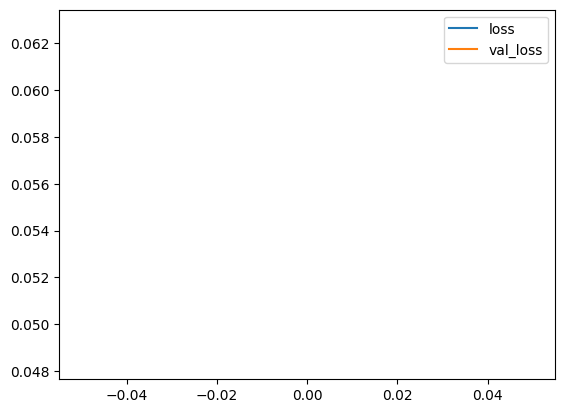

In [30]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

#Make Prediction

In [31]:
input_text = vectorizer('You freaking suck')

In [33]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [35]:
batch = test.as_numpy_iterator().next()

In [36]:
batch_X,batch_y = test.as_numpy_iterator().next()

In [37]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 193ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [34]:
model.predict(np.expand_dims(input_text,0))

1/1 [==============================] - 1s 1s/step


array([[0.96546865, 0.21436755, 0.8571095 , 0.08043841, 0.6683901 ,
        0.16695654]], dtype=float32)

In [40]:
res = model.predict(batch_X)

1/1 [==============================] - 0s 192ms/step


In [43]:
res.flatten().shape

(96,)

#Evaluate Model

In [38]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [39]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [45]:
for batch in test.as_numpy_iterator():
  X_true, y_true = batch
  yhat = model.predict(X_true)

  y_true = y_true.flatten()
  yhat = yhat.flatten()

  pre.update_state(y_true, yhat)
  re.update_state(y_true, yhat)
  acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 192ms/step


In [46]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy: {acc.result().numpy()}')

Precision: 0.8072882294654846, Recall:0.70681232213974, Accuracy: 0.4653961956501007


#Test and Gradio

In [47]:
!pip install gradio jinja2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.4/288.4 kB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 

In [48]:
import gradio as gr

In [49]:
model.save('toxicity_checker.h5')

In [50]:
model = tf.keras.models.load_model('toxicity_checker.h5')

In [55]:
input_str = vectorizer('hey i freaken hate you!')

In [56]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 0s 147ms/step


In [57]:
res

array([[0.7059131 , 0.04136796, 0.32630685, 0.04267386, 0.39057347,
        0.07669977]], dtype=float32)

In [59]:
def score_comment(comment):
  vectorized_comment = vectorizer([comment])
  results = model.predict(vectorized_comment)

  text = ''
  for idx, col in enumerate(df.columns[2:]):
    text +='{}: {}\n'.format(col, results[0][idx]>0.5)

  return text

In [61]:
interface = gr.Interface(fn=score_comment,
                         inputs=gr.inputs.Textbox(lines=2,placeholder='Comment to score'),
                         outputs='text')

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:30: UserWarning: `optional` parameter is deprecated, and it has no effect
  super().__init__(
/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:30: UserWarning: `numeric` parameter is deprecated, and it has no effect
  super().__init__(


In [62]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://82a7672c75d54729b4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
